# 05 - Hyperparameter Tuning

This notebook performs hyperparameter optimization for multiple machine learning models using the selected subset of features.

The goals of this notebook are:

- compare baseline (non-tuned) models  
- search for optimal hyperparameters  
- evaluate model generalization on the test set  
- select the final model to be saved and deployed  

In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import joblib

from src.config import RANDOM_STATE, SELECTED_FEATURES

## 1. Dataset Loading

We load the preprocessed training and test sets as well as the final selected feature subset.


In [2]:
X_train = pd.read_csv("../data/processed/X_train_preprocessed.csv")
X_test  = pd.read_csv("../data/processed/X_test_preprocessed.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

X_train_sel = X_train[SELECTED_FEATURES]
X_test_sel  = X_test[SELECTED_FEATURES]

X_train_sel.head()

,concave_points_mean,concavity_worst,symmetry_worst,radius_avg,perimeter_avg,area_avg,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean
0,-0.398175,-0.610227,0.054566,0.329680,0.227148,0.271332,0.518559,0.891826,0.424632,0.383925,-0.974744,-0.689772,-0.688586,-1.039155,-0.825056
1,-0.303075,-0.712666,-0.137576,-0.567734,-0.579571,-0.541143,-0.516364,-1.639710,-0.541349,-0.542961,0.476219,-0.631834,-0.604281,0.521543,-0.454523
2,-0.765459,-0.431313,-0.675893,-0.154254,-0.344409,-0.274852,-0.368118,0.455515,-0.388250,-0.402970,-1.432979,-0.383927,-0.342175,-0.850857,-0.226171
3,1.213233,2.958619,-0.075646,-0.113585,0.391845,-0.127485,0.205285,0.726168,0.400330,0.070612,0.243253,2.203585,2.256094,0.818474,0.899791
4,0.713767,0.327775,-0.909322,1.259901,1.143881,1.056292,1.243005,0.194195,1.210377,1.206652,-0.111442,0.051348,0.732962,-0.427187,-0.822184


## 2. Baseline Model Performance

Before tuning any hyperparameters, we evaluate each model with default settings.  
This provides a reference (baseline) for comparing improvements obtained through optimization.


In [3]:
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVC (RBF Kernel)": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier()
}

def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    return [
        accuracy_score(y_test, pred),
        precision_score(y_test, pred),
        recall_score(y_test, pred),
        f1_score(y_test, pred),
        roc_auc_score(y_test, prob),
    ]

# Build dataframe
results_baseline = pd.DataFrame(
    [
        evaluate(model, X_train_sel, X_test_sel, y_train, y_test)
        for model in baseline_models.values()
    ],
    index=baseline_models.keys(),
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
)

results_baseline

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic Regression,0.964912,0.952381,0.952381,0.952381,0.992725
Random Forest,0.938596,0.972973,0.857143,0.911392,0.992725
Gradient Boosting,0.964912,1.000000,0.904762,0.950000,0.995040
SVC (RBF Kernel),0.956140,0.974359,0.904762,0.938272,0.985119
KNN,0.938596,0.972973,0.857143,0.911392,0.981647


## 3. Hyperparameter Search Spaces

We define search grids for each algorithm.  
The search spaces are intentionally moderate in size to balance performance and computational cost.


In [4]:
param_spaces = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },

    "Random Forest": {
        "n_estimators": [50, 100, 200, 300],
        "max_depth": [None, 5, 8, 12],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },

    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [2, 3, 4],
        "subsample": [0.8, 1.0]
    },

    "SVC (RBF Kernel)": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"]
    },
    
    "KNN": {
    "n_neighbors": list(range(1, 31)),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
    "p": [1, 2]  # p=1 (Manhattan), p=2 (Euclidean)
    }
}

## 4. RandomizedSearchCV Optimization

RandomizedSearchCV was chosen instead of GridSearchCV because:

- it explores the hyperparameter space more efficiently  
- it finds competitive solutions with fewer iterations  
- it scales better when parameter ranges are large  
- it avoids the combinatorial explosion of full grids  

For most real-world ML tasks, RandomizedSearchCV provides a better performance/cost trade-off.

The best estimator for each model is stored for later evaluation.

In [5]:
tuned_models = {}

for name, model in baseline_models.items():
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_spaces[name],
        n_iter=20,
        cv=5,
        scoring="f1",
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    search.fit(X_train_sel, y_train)
    tuned_models[name] = search.best_estimator_


C:\Users\VVMAT\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\VVMAT\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## 5. Tuned Model Performance

We evaluate the tuned models using the same test set as the baseline.  
This allows direct comparison between both stages.


In [6]:
results_tuned = pd.DataFrame(
    [
        evaluate(model, X_train_sel, X_test_sel, y_train, y_test)
        for model in tuned_models.values()
    ],
    index=tuned_models.keys(),
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
)

results_tuned

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic Regression,0.947368,0.909091,0.952381,0.930233,0.992063
Random Forest,0.938596,0.972973,0.857143,0.911392,0.992063
Gradient Boosting,0.973684,1.000000,0.928571,0.962963,0.992394
SVC (RBF Kernel),0.956140,0.974359,0.904762,0.938272,0.985119
KNN,0.964912,0.975000,0.928571,0.951220,0.972884


## 6. Comparison: Baseline vs Tuned Models

This table shows performance improvements (or regressions) caused by hyperparameter tuning.  
**Primary metric:** F1-score  
We prioritize F1-score due to the medical context, where both precision and recall are critical.

In [7]:
comparison = results_tuned.copy()
comparison["Baseline_F1"] = results_baseline["F1"]
comparison

,Accuracy,Precision,Recall,F1,ROC_AUC,Baseline_F1
Logistic Regression,0.947368,0.909091,0.952381,0.930233,0.992063,0.952381
Random Forest,0.938596,0.972973,0.857143,0.911392,0.992063,0.911392
Gradient Boosting,0.973684,1.000000,0.928571,0.962963,0.992394,0.950000
SVC (RBF Kernel),0.956140,0.974359,0.904762,0.938272,0.985119,0.938272
KNN,0.964912,0.975000,0.928571,0.951220,0.972884,0.911392


### 6.1 Baseline vs Tuned F1-score Summary

This table provides a clear comparison of whether hyperparameter tuning improved each model.


In [8]:
comparison_full = pd.DataFrame({
    "Baseline F1": results_baseline["F1"],
    "Tuned F1": results_tuned["F1"]
})

comparison_full

,Baseline F1,Tuned F1
Logistic Regression,0.952381,0.930233
Random Forest,0.911392,0.911392
Gradient Boosting,0.950000,0.962963
SVC (RBF Kernel),0.938272,0.938272
KNN,0.911392,0.951220


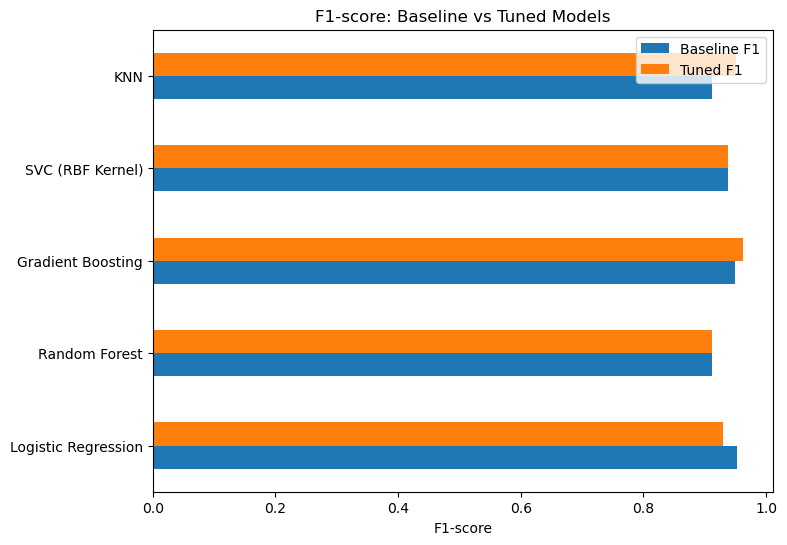

In [29]:
comparison_full.plot(kind="barh", figsize=(8,6))
plt.title("F1-score: Baseline vs Tuned Models")
plt.xlabel("F1-score")
plt.show()

## 7. Final Model Selection

The best-performing model is selected based on test F1-score.  
This model will be saved and used for inference.


In [9]:
best_model_name = comparison["F1"].idxmax()
best_model = tuned_models[best_model_name]

print("Best model selected:", best_model_name)
print("\nBest estimator:", best_model)

Best model selected: Gradient Boosting

Best estimator: GradientBoostingClassifier(learning_rate=0.2, max_depth=2, random_state=42,
                           subsample=0.8)


### 7.1 Final Model Confusion Matrix

The confusion matrix provides additional insight into the types of errors made by the final model, 
which is especially relevant in medical applications where false negatives have high cost.


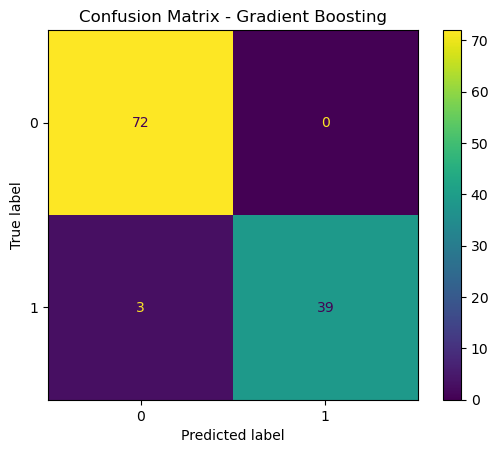

In [33]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test_sel, y_test)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

## 8. Saving the Final Model

We export the final tuned model as a `.pkl` file using joblib.  
This model can now be loaded directly for prediction, evaluation, or deployment.

We import the scaler used in the preprocessing step so that it can be included in the final model bundle.  
Saving the scaler separately ensures full reproducibility during evaluation and allows experimentation with alternative scaling strategies in future iterations.


In [11]:
scaler = joblib.load("../src/models/scaler.pkl")

In [12]:
joblib.dump({
    "model": best_model,
    "scaler": scaler,
    "features": SELECTED_FEATURES
},
    "../src/models/final_model.pkl"    
)

['../src/models/final_model.pkl']

## 9. Conclusion

In this notebook, we compared several machine learning models, optimized their hyperparameters, and selected the one that achieved the highest F1 performance on the test set.

This hyperparameter tuning step completes the modeling pipeline and prepares the final model for deployment.  
The next step consists of building the evaluation report, generating explainability (SHAP/LIME), and integrating the model into the project structure.
